# Frequency analysis and sentiment with NLTK

find_word_freq_readfiles.ipynb

### 1 ###
•	It reads the dataframe with the analysis (file_df_analysis) and the dataframe with the histogram (file_df_analysis_hist) information created by “analyse_papers.ipynb”
•	Frequency analysis of the sentence where a paper was cited. It finds a representative sentence showing how the a paper has been cited in the different sections. It is selected by getting the list of sentences containing the maximum number of most frequent words used when citing the paper (in each section). If there are several sentences it picks the shortest one.

### 2 ###
•	Sentiment analysis using NLTK.



##############################################################


### 1 ###
•	It reads the dataframe with the analysis (file_df_analysis) and the dataframe with the histogram (file_df_analysis_hist) information created by “analyse_papers.ipynb”
•	Frequency analysis of the sentence were a paper was cited. It finds a representative sentence showing how the a paper has been cited in the different sections. It is selected by getting the list of sentences containing the maximum number of most frequent words used when citing the paper (in each section). If there are several sentences it picks the shortest one.


In [20]:
%matplotlib inline

In [21]:
import sys
import os
import re
from copy import deepcopy
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

sys.path.insert(0, "./modules")
import words_frec_analysis_get_sentence

# Configuration

In [22]:
data_path = 'data'

#ds_name = 'DOI_cited_science_1179052_retracted'


%store -r file_df
%store -r cited_DOI_to_analyse

ds_name = file_df


analysis_path = os.path.join(data_path, 'analysis')

# In
citing_sections_tsv = os.path.join(analysis_path, '%s_sections.tsv' % ds_name)
analysis_hist_tsv = os.path.join(analysis_path, '%s_hist.tsv' % ds_name)

In [23]:
ds_name

'DOI_cited_science_1179052_retracted'

# Setup

In [24]:
# One time download
nltk.download("stopwords")
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Analysis

In [25]:
df_all_DOIs = pd.read_csv(citing_sections_tsv, sep='\t', encoding='utf-8')
df_all_DOIs.head()

df = df_all_DOIs[df_all_DOIs.cited_DOI == cited_DOI_to_analyse]
df.head()


,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_number,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_intro,sentence_citing_maintext
0,10.1126/science.1179052,False,False,False,True,10.1186/1741-7007-8-124,False,False,False,True,B1,NaN,NaN,NaN,"['[<xref ref-type=""bibr"" rid=""B1"">1</xref>] re..."
1,10.1126/science.1179052,False,False,True,False,10.1186/1471-2180-11-2,True,True,True,True,B8,NaN,NaN,['The most recent example is xenotropic murine...,NaN
2,10.1126/science.1179052,True,False,False,False,10.1186/1471-2377-11-37,True,True,True,True,B47,['This report of the possible contribution of ...,NaN,NaN,NaN
3,10.1126/science.1179052,False,False,False,False,10.1186/1471-2377-11-62,True,True,True,True,B43,NaN,NaN,NaN,NaN
4,10.1126/science.1179052,False,False,True,False,10.1186/1471-2377-11-82,True,True,True,True,B31,NaN,NaN,['Novel retroviruses may also be involved [<xr...,NaN


In [26]:
df_hist_all_DOIs = pd.read_csv(analysis_hist_tsv, sep='\t', encoding='utf-8')
df_hist = df_hist_all_DOIs[df_hist_all_DOIs.DOI_cited == cited_DOI_to_analyse]
df_hist

,DOI_cited,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,papers_all_sections_found,total_papers_citing
0,10.1126/science.1179052,0.102564,0.358974,0.538462,0.769231,39,43


In [27]:
df_filtered = df['sentence_citing_maintext'].dropna()

df_filtered

0     ['[<xref ref-type="bibr" rid="B1">1</xref>] re...
5     ['Recently, a link between the xenotropic muri...
6     ['Evidence of xenotropic murine leukemia virus...
8     ['These deficiencies in NK activity may increa...
9     ['Both cell associated and cell-free transmiss...
11    ['More recently, Lombardi,<italic>et al</itali...
12    ['reported finding a gammaretrovirus in periph...
13    ['[<xref ref-type="bibr" rid="B8">8</xref>] (T...
14    ['More recently, XMRV has also been found, wit...
15    ['In 2009, a high incidence of XMRV infection ...
17    ['Remarkably, the 22Rv1 sequences displayed av...
18    ['<html><body><p>c&gt;<sec><title>Results and ...
19    ['Plasma samples of CFS patients were simultan...
22    ['In addition, we collected 37 blood samples (...
23    ['Thus there was no linkage between viral DNA ...
24    ['Hamster Lec8 cells have a glycosylation defe...
27    ['reported finding XMRV in 67% of persons with...
28    ['Most importantly, we did not find antibo

#### Let's find the most frequent words in an example of a representative sentence for each section (intro, discussion, etc) where the paper is cited.

In [29]:
df = pd.read_csv(citing_sections_tsv, sep='\t', encoding='utf-8')
#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']


print('cited_DOI: ', df.cited_DOI.unique())


print("\n------------- ANALYSIS INTRODUCTION -----------")
sentences_intro = df.sentence_citing_intro.dropna()
if not sentences_intro.empty:
    words_frec_analysis_get_sentence.analysis(sentences_intro)
else:
    print("No sentences to analyse")

print("\n------------- ANALYSIS MAINTEXT -----------")
sentences_maintext = df.sentence_citing_maintext.dropna()
if not sentences_maintext.empty:
    words_frec_analysis_get_sentence.analysis(sentences_maintext)
else:
    print("No sentences to analyse")

print("\n------------- ANALYSIS DISCUSSION -----------")
sentences_discussion = df.sentence_citing_discussion.dropna()
if not sentences_discussion.empty:
    words_frec_analysis_get_sentence.analysis(sentences_discussion)
else:
    print("No sentences to analyse")
    
    
print("\n ------------- ANALYSIS CONCLUSIONS -----------")

sentences_conclusions = df.sentence_citing_conclusions.dropna()
if not sentences_conclusions.empty:
    words_frec_analysis_get_sentence.analysis(sentences_conclusions)
else:
    print("No sentences to analyse")    


cited_DOI:  ['10.1126/science.1179052']

------------- ANALYSIS INTRODUCTION -----------
Most frequent words:  ['cfs', 'patients', 'syndrome', 'virus', 'xmrv']
Frequent words included:  [0, 0, 0, 4, 5, 6, 0, 3, 0, 0, 0, 4, 4, 5, 0, 6, 3, 5, 0, 1, 2]
Maximum words in the same sentence  =  6

 Representative sentence:
17,"['<sec><title>Introduction</title><p>Reports of a newly-discovered gammaretrovirus (xenotropic murine leukemia virus-related virus; XMRV) in patients diagnosed with prostate cancer [<xref ref-type=""bibr"" rid=""B1"">1</xref>,<xref ref-type=""bibr"" rid=""B2"">2</xref>] and chronic fatigue syndrome (CFS) [<xref ref-type=""bibr"" rid=""B3"">3</xref>] have attracted the attention of investigators throughout the retroviral research community.']"

------------- ANALYSIS MAINTEXT -----------
Most frequent words:  ['cfs', 'chronic', 'patients', 'samples', 'xmrv']
Frequent words included:  [2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 3, 0, 4, 8, 2, 0, 4, 0, 0, 0, 1, 1, 3, 4, 4, 3, 0, 3, 

### 2 ###


In [30]:
print("\n Sentiment analysis using NLTK.")


 Sentiment analysis using NLTK.


In [31]:
stopwords = nltk.corpus.stopwords

def filter_sentence(citing_sentence):
    if citing_sentence == None:
        return " " #filtered_sentences_noNone.append(" ")
    
    if citing_sentence != None:
        citing_sentence = re.sub("[\<\[].*?[\>\]]", "", citing_sentence) #to remove citations
        #citing_sentence = re.sub("[*?]", "", citing_sentence) #to remove citations
        citing_sentence = re.sub('[0-9]+', '', citing_sentence)
        delete = ["Introduction", "Background", "Conclusions","the", "and", "therefore", "thus"]#, "\n", "<\sub>", "bibr", "ref", "rid", "type", "xref"] #, "/p\np\n", "\p"]
        for word in delete:
            citing_sentence = re.sub(word, "", citing_sentence) 
        #citing_sentence = re.sub("\?", "", citing_sentence) #to remove citations
        citing_sentence = ' '.join([word for word in citing_sentence.split() if word not in (stopwords.words('english'))])
        return citing_sentence # O ?????????filtered_sentences_noNone.append(sentence[0])

def fit_transform_or_empty(vectorizer, data):
    return count_vectorizer.fit_transform(data) if len(data) > 0 else csr_matrix([])

#file_df = '/project/elife/data/analysis/df_1000_1000v2_prep_.csv'
df = pd.read_csv(citing_sections_tsv, sep='\t', encoding='utf-8')

#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']
    


count_vectorizer = CountVectorizer(max_features=5)
#sentence = ''.join(str(string) for string in citing_sentences_list)
#sentence = sentence.decode('utf-8')
#u_sentence = unicode( sentence, "utf-8" )
#backToBytes = u_sentence.encode( "utf-8" )



#sentence = re.sub(r',([0-9])', '\\1', sentence)
# sort out HMTL formatting of &
#sentence = re.sub(r'&amp', 'and', sentence)

citing_sentences_intro_list = df.sentence_citing_intro.dropna()
citing_sentences_maintext_list = df.sentence_citing_maintext.dropna()
citing_sentences_discussion_list = df.sentence_citing_discussion.dropna()
citing_sentences_conclusions_list = df.sentence_citing_conclusions.dropna()
    
citing_sentences_original_intro = deepcopy(citing_sentences_intro_list)
citing_sentences_original_maintext = deepcopy(citing_sentences_maintext_list)
citing_sentences_original_discussion = deepcopy(citing_sentences_discussion_list)
citing_sentences_original_conclusions = deepcopy(citing_sentences_conclusions_list) # This is a list of lists, so you need deepcopy

filtered_sentences_intro_list = citing_sentences_intro_list.apply(filter_sentence)
filtered_sentences_maintext_list = citing_sentences_maintext_list.apply(filter_sentence)
filtered_sentences_discussion_list = citing_sentences_discussion_list.apply(filter_sentence)
filtered_sentences_conclusions_list = citing_sentences_conclusions_list.apply(filter_sentence)        

#filtered_sentences_intro_list = [filter_sentence(sentence) for sentence in citing_sentences_intro_list]
#filtered_sentences_maintext_list = [filter_sentence(sentence) for sentence in citing_sentences_maintext_list]
#filtered_sentences_discussion_list = [filter_sentence(sentence) for sentence in citing_sentences_discussion_list]
#filtered_sentences_conclusions_list = [filter_sentence(sentence) for sentence in citing_sentences_conclusions_list]

#print(filtered_sentences_intro_list)
#citing_sentences_intro_list.apply(filter_sentence)

count_vectors_intro = fit_transform_or_empty(count_vectorizer, filtered_sentences_intro_list)
#print(count_vectorizer.get_feature_names())
#word_frequency_intro = count_vectors_intro.toarray()

count_vectors_maintext = fit_transform_or_empty(count_vectorizer, filtered_sentences_maintext_list)
#print(count_vectorizer.get_feature_names())
#word_frequency_maintext = count_vectors_maintext.toarray()

count_vectors_discussion = fit_transform_or_empty(count_vectorizer, filtered_sentences_discussion_list)
#print(count_vectorizer.get_feature_names())
#word_frequency_discussion = count_vectors_discussion.toarray()

count_vectors_conclusions = fit_transform_or_empty(count_vectorizer, filtered_sentences_conclusions_list)
#print(count_vectorizer.get_feature_names())
#word_frequency_conclusions = count_vectors_conclusions.toarray()


#print(word_frequency_intro)
#print(word_frequency_maintext)
#print(word_frequency_discussion)
#print(word_frequency_conclusions)

number_words_in_sentence_intro = np.sum(count_vectors_intro.toarray(),axis=1).tolist()
number_words_in_sentence_maintext = np.sum(count_vectors_maintext.toarray(),axis=1).tolist()
number_words_in_sentence_discussion = np.sum(count_vectors_discussion.toarray(),axis=1).tolist()
number_words_in_sentence_conclusions = np.sum(count_vectors_conclusions.toarray(),axis=1).tolist()



#print("Frequent words included (intro): ", number_words_in_sentence_intro)
#print("Frequent words included (maintext): ", number_words_in_sentence_maintext)
#print("Frequent words included (discussion): ", number_words_in_sentence_discussion)
#print("Frequent words included (conclusions): ", number_words_in_sentence_conclusions)

#print("maximum words in the same sentence in introduction =", max(number_words_in_sentence_intro))
#print("maximum words in the same sentence in maintext =", max(number_words_in_sentence_maintext))
#print("maximum words in the same sentence in discussion =", max(number_words_in_sentence_discussion))
#print("maximum words in the same sentence in conclusions =", max(number_words_in_sentence_conclusions))

"""
df_sentences_intro = pd.DataFrame({"citing_intro_sentence" : filtered_sentences_intro_list, 
                                 "number_frequent_words" : number_words_in_sentence_intro})
"""
# length of sentence

sentence_length_intro = []
for sentence in citing_sentences_intro_list:
    if sentence == None:
        sentence_length_intro.append(0)
    if sentence != None:
        sentence_length_intro.append(len(sentence))

df_sentences_intro = pd.DataFrame({"frequent_words" : number_words_in_sentence_intro,
                                "citing_sentence" : citing_sentences_original_intro,
                                "sentence_length": sentence_length_intro})


sentences_toCheck = df_sentences_intro[(df_sentences_intro["frequent_words"] == max(df_sentences_intro["frequent_words"]))] #['sentence_citing_intro']
min_length= min(sentences_toCheck["sentence_length"][:])
#print("min_length: ", min_length)

sentence = sentences_toCheck[sentences_toCheck['sentence_length'] == min_length]["citing_sentence"]

# To print the full content
sentence.to_csv(sys.stdout)

17,"['<sec><title>Introduction</title><p>Reports of a newly-discovered gammaretrovirus (xenotropic murine leukemia virus-related virus; XMRV) in patients diagnosed with prostate cancer [<xref ref-type=""bibr"" rid=""B1"">1</xref>,<xref ref-type=""bibr"" rid=""B2"">2</xref>] and chronic fatigue syndrome (CFS) [<xref ref-type=""bibr"" rid=""B3"">3</xref>] have attracted the attention of investigators throughout the retroviral research community.']"


In [32]:
df = pd.read_csv(citing_sections_tsv, sep='\t', encoding='utf-8')

citing_sentences_intro= df['sentence_citing_maintext']
citing_sentences_intro_list = citing_sentences_intro.tolist()
#print(citing_sentences_intro_list[1])

count_vectorizer = CountVectorizer(max_features=5)
#sentence = ''.join(str(string) for string in citing_sentences_list)
#sentence = sentence.decode('utf-8')
#u_sentence = unicode( sentence, "utf-8" )
#backToBytes = u_sentence.encode( "utf-8" )



#sentence = re.sub(r',([0-9])', '\\1', sentence)
# sort out HMTL formatting of &
#sentence = re.sub(r'&amp', 'and', sentence)

# If you want to avoid to go through all the papers, you can select those with introductions by
# by replacing citing_sentences_intro_list by df_intro_filtered.tolist()


citing_sentences_original = deepcopy(citing_sentences_intro_list) # This is a list of lists, so you need deepcopy
#print(citing_sentences_original[19])
filtered_sentences_noNone = []
filtered_sentences = citing_sentences_intro_list[:]
#print(filtered_sentences[0:1])
for sentence in filtered_sentences:
    if (type(sentence) == float):
        filtered_sentences_noNone.append(" ")
    if (type(sentence) != float):
        #print("######################### ", type(sentence), sentence)
        delete = ["Introduction", "Background", "the", "and"]
        for word in delete:
            sentence = re.sub(word, "", sentence) 
        sentence = re.sub("[\<\[].*?[\>\]]", "", sentence) #to remove cititations
        sentence = ' '.join([word for word in sentence.split() if word not in (stopwords.words('english'))])
        filtered_sentences_noNone.append(sentence)

count_vectorizer.fit_transform(filtered_sentences_noNone) #backToBytes
#print(citing_sentences_original[19]) 
    
#print(count_vectorizer.get_feature_names())
count_vectors = count_vectorizer.transform(filtered_sentences_noNone)

word_frequency = count_vectors.toarray()
#print(word_frequency)
number_words_in_sentence = np.sum(count_vectors.toarray(),axis=1).tolist()

#print("Frequent words included: ", number_words_in_sentence)


#print(citing_sentences_intro_list)
print("maximum words in the same sentence =", max(number_words_in_sentence))

#df_introCiting = pd.DataFrame({"citing_intro_sentence" : filtered_sentences_noNone, 
#                                "number_frequent_words" : number_words_in_sentence})
#print(df_introCiting)

# length of sentence
sentence_length = []
for sentence in citing_sentences_intro_list:
    if (sentence == None) | (sentence == np.nan):
        sentence_length.append(0)
    if (sentence != None) & (sentence != np.nan):
        sentence_length.append(len(str(sentence)))



df_introCiting = pd.DataFrame({"frequent_words" : number_words_in_sentence,
                                "citing_sentence" : citing_sentences_original,
                                "sentence_length": sentence_length})


sentences_toCheck = df_introCiting[(df_introCiting["frequent_words"] == max(df_introCiting["frequent_words"]))] #['sentence_citing_intro']
min_length= min(sentences_toCheck["sentence_length"][:])

sentence = sentences_toCheck[sentences_toCheck['sentence_length'] == min_length]["citing_sentence"]

# To print the full content
sentence.to_csv(sys.stdout)



maximum words in the same sentence = 11
23,"['Thus there was no linkage between viral DNA detection and<italic>RNASEL</italic>R462Q in our clinical samples (Table<xref ref-type=""table"" rid=""T5"">5</xref>).</p><table-wrap id=""T4"" position=""float""><label>Table 4</label><caption><p><italic>RNASEL</italic>genotyping and tumor grade</p></caption><table frame=""hsides"" rules=""groups""><thead><tr><th></th><th align=""center""><bold>Normal/benign</bold><sup><bold><italic>a</italic></bold></sup></th><th align=""center""><bold>Intermediate</bold><sup><bold><italic>b</italic></bold></sup></th><th align=""center""><bold>High</bold><sup><bold><italic>c</italic></bold></sup></th><th align=""center""><bold>Total</bold><sup><bold><italic>d</italic></bold></sup></th></tr></thead><tbody><tr><td align=""left""><italic>RNASEL</italic>RR</td><td align=""center"">11</td><td align=""center"">28</td><td align=""center"">15</td><td align=""center"">54</td></tr><tr><td align=""left""><italic>RNASEL</it

In [36]:
sid = SentimentIntensityAnalyzer()


df_sentiment = df_introCiting.copy()

df_sentiment2 = filtered_sentences_noNone
ss2 = sid.polarity_scores(df_sentiment2[0])

sentiment_scores_list = []
for sentence in df_sentiment2:
    ss2 = sid.polarity_scores(sentence) # from twython  package
    sentiment_scores_list.append(ss2)
df_sentiment_scores = pd.DataFrame(sentiment_scores_list)


df_sentiment = df_sentiment.join(df_sentiment_scores)

df_sentiment



,citing_sentence,frequent_words,sentence_length,compound,neg,neu,pos
0,"['[<xref ref-type=""bibr"" rid=""B1"">1</xref>] re...",1,231,-0.3400,0.224,0.658,0.118
1,NaN,0,3,0.0000,0.000,0.000,0.000
2,NaN,0,3,0.0000,0.000,0.000,0.000
3,NaN,0,3,0.0000,0.000,0.000,0.000
4,NaN,0,3,0.0000,0.000,0.000,0.000
5,"['Recently, a link between the xenotropic muri...",0,278,0.0000,0.000,1.000,0.000
6,['Evidence of xenotropic murine leukemia virus...,0,251,0.0000,0.000,1.000,0.000
7,NaN,0,3,0.0000,0.000,0.000,0.000
8,['These deficiencies in NK activity may increa...,0,262,0.0000,0.000,1.000,0.000
9,['Both cell associated and cell-free transmiss...,0,181,0.0000,0.000,1.000,0.000


# Plot. Sentiment score for each paper in the list.

In [37]:
print("\n Sentiment analysis using NLTK.")


 Sentiment analysis using NLTK.


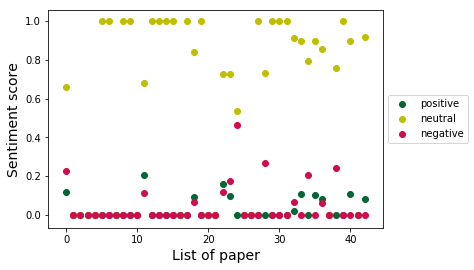

In [51]:
x = np.arange(len(df_sentiment))
df_sentiment['compound']

#plt.close()
#comp = plt.scatter(x,df_sentiment['compound'])
pos = plt.scatter(x,df_sentiment['pos'], color = "#046535")
neu = plt.scatter(x,df_sentiment['neu'], color = 'y')
neg = plt.scatter(x,df_sentiment['neg'], color = "#CF0C4E")

#Blue 0961AB; Purple 732060; Light Green 629F43; Rubine red CF0C4E; Light blue 0A9DD9; 
#Dark green 046535; Dark blue 273B81; brighter purple 800080; Grey 6D6E70]

plt.legend((pos, neu, neg),('positive', 'neutral','negative'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("List of paper", fontsize=14)
plt.ylabel("Sentiment score", fontsize=14)

plt.savefig("sentiment.png")
plt.show()
